<a href="https://colab.research.google.com/github/GamaLab42/LivroBioprocessos/blob/main/Modelagem_Coluna_cromatogr%C3%A1fica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas

In [ ]:
#@title
# Bibliotecas
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy import integrate

# Para o modelo de coluna
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sys import argv

import math
from numba import njit


In [ ]:
## Iniciar as constantes utilizadas no modelo

T         = 298.15            # Temperatura
kb        = 1.3806E-23        # Constante de Boltzmann
epsilon   = 80.0              # Constante dielétrica do meio (-)
epsilon0  = 8.854E-12         # Constante dielétrica do vácuuo (C^2 m-1 J-1)
Na        = 6.022E+23         # Numero do Avogrado
F         = 96.485E+3         # Constante de Faraday (C mol-1)
e         = 1.602176E-19      # Carga elementar do eletron (C)

dw01        = 1.70E-11           # Comprimento da camada de água na parede (m)
dw02        = 1.70E-10           # Comprimento da camada de água na parede (m)

## Comprimento de Debye

In [ ]:
# Função que determina a constante de Debye (m)
# Input: concentração iônica em mol L-1

def kappa (Conc):

  kappa = np.sqrt(np.power(e,2)*Na*float(2)*Conc*float(1000)/epsilon/epsilon0/kb/T)

  return kappa

## Cálculo do parâmetro de afinidade (Henry - m)


In [ ]:
dwp = 0.12E-9

In [ ]:
def G_total(L,sigma_s,sigma_p, H, conc, d_lim):
  dist = L + d_lim

  kappa = np.sqrt(np.power(e,2)*Na*float(2)*conc*float(1000)/epsilon/epsilon0/kb/T)

  den = (sigma_s*sigma_s + sigma_p*sigma_p)*np.exp(-kappa*dist)+2*sigma_s*sigma_p
  G_ele = den/kappa/epsilon/epsilon0/(np.exp(kappa*dist) - np.exp(-kappa*dist))

  G_vdW = - H/12/np.pi/dist/dist

  return G_ele + G_vdW

In [ ]:
def fHenry(L,sigma_s,sigma_p, H, conc, Ap):

  dist = L

  kappa = np.sqrt(np.power(e,2)*Na*float(2)*conc*float(1000)/epsilon/epsilon0/kb/T)

  den = (sigma_s*sigma_s + sigma_p*sigma_p)*np.exp(-kappa*dist)+2*sigma_s*sigma_p
  G_ele = - Ap * den/kappa/epsilon/epsilon0/kb/T/(np.exp(kappa*dist) - np.exp(-kappa*dist))

  G_vdW = Ap * H/12.0/np.pi/dist/dist/kb/T

  return np.exp((G_ele + G_vdW)) - 1

In [ ]:
import warnings

# Função de tratamento do aviso

def handle_warning(message, category, filename, lineno, file=None, line=None):
    global lim
    print("Aviso RuntimeWarning:", message)
    lim = dwp  # Defina lim como dw

# Registrar a função de tratamento de aviso
warnings.showwarning = handle_warning

# Filtrar os avisos do tipo RuntimeWarning para serem tratados como exceções
warnings.simplefilter("error", RuntimeWarning)

In [ ]:
def limite(delta_s, delta_p, Ham, Ist, d_lim, Ap):
  try:
    zero = fsolve(G_total, 1.9*dw02, args=(delta_s, delta_p, Ham, Ist, dw01))
    lim = zero[0]
  except RuntimeWarning:
    lim = d_lim
  return lim

In [ ]:
# Calculo do parâmetro de afinidade (m)

fase      = 3.40E+6
conc_min  = 0.05

def Henry (sigma_s, sigma_p, Ist, Hamaker, Ap):

  result = integrate.quad(lambda x: fHenry(x, sigma_s, sigma_p, Hamaker, (Ist+conc_min), Ap),limite(sigma_s, sigma_p, Hamaker, (Ist + conc_min), dwp, Ap), 10.0E-9)

  return (fase*result[0])

In [ ]:
Is      = []
K_cyto  = []
K_ribo  = []

conc = 8
conc_min = 0.05
passo = 100

delta = (conc-conc_min)/passo

sigma_s = -0.220

for i in range(0,passo):
  Is.append(delta*i+conc_min)
  K_cyto.append(Henry(sigma_s, 0.0430, delta*i, 0.940E-21, 4.410E-17/2.0))
  K_ribo.append(Henry(sigma_s, 0.0387, delta*i, 1.240E-21, 4.160E-17/2.0))

In [ ]:
Ionic_Strength_min = 1.0
Ionic_Strength_max = 8.0
Ionic_Strength_max2 = 5.0

In [ ]:
K_cyto_min = Henry(sigma_s, 0.0430, Ionic_Strength_min, 0.940E-21, 4.410E-17/2.0)
K_ribo_min = Henry(sigma_s, 0.0387, Ionic_Strength_min, 1.240E-21, 4.160E-17/2.0)

K_cyto_max = Henry(sigma_s, 0.0430, Ionic_Strength_max, 0.940E-21, 4.410E-17/2.0)
K_ribo_max = Henry(sigma_s, 0.0387, Ionic_Strength_max, 1.240E-21, 4.160E-17/2.0)

In [ ]:
# Para a lisozima

dwp = 0.16E-9

import warnings

# Função de tratamento do aviso
def handle_warning(message, category, filename, lineno, file=None, line=None):
    global lim
    print("Aviso RuntimeWarning:", message)
    lim = dwp  # Defina lim como dw

# Registrar a função de tratamento de aviso
warnings.showwarning = handle_warning

# Filtrar os avisos do tipo RuntimeWarning para serem tratados como exceções
warnings.simplefilter("error", RuntimeWarning)

K_lys  = []

for i in range(0,passo):
  K_lys.append(Henry(sigma_s, 0.050, delta*i, 1.550E-21, 4.410E-17/2.0))

In [ ]:
K_lys_min = Henry(sigma_s, 0.050, Ionic_Strength_min, 1.550E-21, 4.410E-17/2.0)

K_lys_max = Henry(sigma_s, 0.050, Ionic_Strength_max2, 1.550E-21, 4.410E-17/2.0)

(0.0, 5.0)

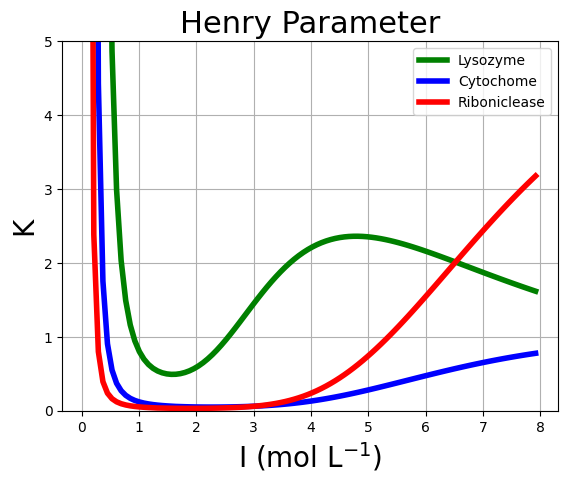

In [ ]:
plt.plot((Is), (K_lys), color = 'green',  label = 'Lysozyme',linewidth=4.0)

plt.plot((Is), (K_cyto), color = 'blue',  label = 'Cytochome',linewidth=4.0)

plt.plot((Is), (K_ribo), color = 'red',  label = 'Riboniclease',linewidth=4.0)

plt.title('Henry Parameter', fontsize=22)
plt.ylabel('K', fontsize=20)
plt.xlabel('I (mol L$^{-1}$)', fontsize=20)

plt.grid()
plt.legend()
plt.ylim(0,5)
#plt.xlim(0,5.0)

In [ ]:
[K_cyto_min,
 K_ribo_min,
 K_cyto_max,
 K_ribo_max,
 K_lys_min,
 K_lys_max]

[0.11071752881399509,
 0.0499135566356586,
 0.7925146087072313,
 3.2713946946407,
 0.7380881937410141,
 2.348945876465177]

## Coeficiente de transferência de massa

In [ ]:
Ma_lys  = 1.44E+4   # massa molecular (kDa)
Ma_cyt  = 1.24E+4   # massa molecular (kDa)
Ma_ribo = 1.37E+4   # massa molecular (kDa)

ub = 0.9           # viscosidade da água (cP)
T = 298.15

dp = 1.93E-3       # Diâmetro da fase estacionária (cm)
ep = 0.74
kb = 1.38E-23


In [ ]:
# Constante do leito
et    = 0.53E0          # Porosidade do leito
As    = 4.2E+7          # Área superficial acessível
DC    = 0.50E0          # Diâmetro do leito (cm)
COMP  = 8.5E0           # Comprimento do leito (cm)

VAZAO   = 1E-1          # Vazão de alimentação [CM3/MIN]
SECAO = np.pi*(DC/2.0)**2         # Seção transversal da coluna (cm2)
VC    = np.pi*DC**2.0*COMP/4.0    # Volume da coluna (cm3)
V     = VAZAO/(SECAO*et)          # Velocidade intersticial

In [ ]:
def Young(Ma,T):
  return 8.34E-8*T/ub/Ma**(1/3)*60  #cm2/min

In [ ]:
def kf(Ma,u,dp,T):
  return np.sqrt(4*Young(Ma,T)*u/np.pi/dp)

In [ ]:
def Dp(Ma,ep,T):
  return Young(Ma,T)*(ep/(2-ep))**2 # cm2/min

In [ ]:
def km_new(Ma,u,dp,ep,T):
  return (dp/6/kf(Ma,u,dp,T) + dp**2/60/ep/Dp(Ma,ep,T))**(-1)

In [ ]:
km = []
km.append(km_new(Ma_lys,V,dp,ep,T)) # liso
km.append(km_new(Ma_cyt,V,dp,ep,T)) # cyto
km.append(km_new(Ma_ribo,V,dp,ep,T)) # ribo

Valores do coeficiente de transferência de massa

In [ ]:
[km[0],km[1],km[2]]

[195.41506075572525, 203.84634020652078, 198.18826178568827]

Parâmetro de Henry

In [ ]:
H1 = []
ratio = et/(1-et)
H1.append(K_lys_max*ratio)
H1.append(K_cyto_max*ratio)
H1.append(K_ribo_max*ratio)

In [ ]:
H1 = []
ratio = et/(1-et)
H1.append(K_lys_min*ratio)
H1.append(K_cyto_min*ratio)
H1.append(K_ribo_min*ratio)

In [ ]:
H1

[0.8323122184739097, 0.12485168142854768, 0.05628550003595545]

## Re-escrevendo os códigos para implementação na coluna
Nessa etapa, as funções serão atribuidas ao @njit com a finalidade de diminuir o tempo computacional

## Modelo da coluna

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip --version

pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


In [ ]:
# Início do modelo da coluna
!git clone https://github.com/asanet/dasslc2py

Cloning into 'dasslc2py'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 74 (delta 3), reused 1 (delta 0), pack-reused 63
Receiving objects: 100% (74/74), 408.18 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
!pip install -e ./dasslc2py

Obtaining file:///content/dasslc2py
  Preparing metadata (setup.py) ... done
  Running setup.py develop for Dasslc2py


In [ ]:
#restart runtime for import to work
!ls dasslcy

ls: cannot access 'dasslcy': No such file or directory


In [ ]:
import os
import numpy as np
import math

import matplotlib.pyplot as plt
from numba import njit

os.chdir("dasslc2py")
os.listdir()


['model4b.dat',
 'dasslc',
 'model4.dat',
 'build',
 'dasslc.cpython-310-x86_64-linux-gnu.so',
 'README.md',
 'dasslc_example.py',
 'LICENSE.txt',
 'setup.py',
 'sparse',
 'dasslcmodule.c',
 '.git',
 'Dasslc2py.egg-info',
 'model3.dat']

In [ ]:
#!cat dasslc2py/dasslc_example.py #para vizualizar o código de exemplos

In [ ]:
#exec(open("dasslc_example.py").read()) #para executar TODOS os exemplos do pacote

In [ ]:
H1[0]

0.8323122184739097

## Definição das constantes e função residual

Numba is used for Just in time compilation

In [ ]:
#Definindo o tamanho dos vetores e matrizes
import dasslc, time

NELEM = 250             # Número de elementos finitos
NCOMP = 3              # Número de componentes
NEQ   = 2*NELEM*NCOMP  # Número de equações a serem resolvidas

# Constante do leito
#et    = 0.53E0          # Porosidade do leito
#As    = 4.2E+7          # Área superficial acessível
#DC    = 0.50E0          # Diâmetro do leito (cm)
#COMP  = 8.5E0           # Comprimento do leito (cm)

# Parametro de equilibrio
qmax  = [1295.09, 1295.09, 1295.09]   # Capacidade máxima de adsorção

# Condicao de operacao
CF0   = np.zeros(NCOMP)
CF0   = [1.0,1.0,1.0]       # Concentração de alimentação de cada compoente [G/L]

TOP     = 60.0E0        # Tempo de operação [MIN]
VFEED   = 10E-2        # Volume de Alimentação [CM3]
INJECAO = 0             # Flag de identificação do tipo de alimentação
#VAZAO   = 1E-1          # Vazão de alimentação [CM3/MIN]

PE      = [1000.0,1000.0,1000.0]   # Peclet

cmod    = np.array([1.*58.5, 1.*58.5])  #	CMOD(1) = 4.D0,	CMOD(2) = cf0(ncomp) - 58.5 é a massa molar do NaCl
TFINI   = 0.0E0          #	TGINI   = 0.D0
TGEND   = 10.0E0         #	TGEND   = 10.D0
S       = 0.4E0          #	S       = 1.D0

# Parametro da discretizacao
BE      =  np.zeros(NELEM*NCOMP)

SPARSE = False # Change it to True if sparse was compiled
# it0 = time.time()

PN    = NELEM
#SECAO = np.pi*(DC/2.0)**2         # Seção transversal da coluna (cm2)
#VC    = np.pi*DC**2.0*COMP/4.0    # Volume da coluna (cm3)
#V     = VAZAO/(SECAO*et)          # Velocidade intersticial
CF0[NCOMP-1] = cmod[1]

#.........................................................
# CALCULANDO VETORES DA DISCRETIZAÇÃO EM Z
#.........................................................
for i in range(0,(NCOMP)):
    BE[i*NELEM]=2.0+(6.0*PN)/PE[i]
    for j in range(1,(NELEM)):
        BE[j+i*NELEM]=4.0-1.0/BE[(j+i*NELEM)-1]

cb0 = np.zeros(NCOMP)
p   = np.zeros((NCOMP,(NELEM+1)))
g   = np.zeros(NELEM*NCOMP)

@njit
def model2(t,y,yp,par): #------------- Maximum of 4 input arguments

    # cb0 = np.zeros(NCOMP)
    # p   = np.zeros((NCOMP,(NELEM+1)))
    # g   = np.zeros(NELEM*NCOMP)

    cb0, p, g, BE, CF0, cmod, PE, qmax, km, H1 = par

    res = np.zeros((NEQ,))
#! ......................................................
#!     definindo variáveis auxiliares
#! ......................................................
    naux1 = NCOMP*NELEM

    #H1 = np.zeros(NCOMP)

#! ......................................................
#!     balanço de massa na fase fluida
#! ......................................................

    if (INJECAO == 0):
        #if (t*COMP/V <= 1):
        #    cb0[1] = 0.0
            #cb0[NCOMP-1] = 0.0
        #if (t*COMP/V > 1 and t*COMP/V <= 60):
            #cb0[NCOMP-1] = cmod[0]/CF0[NCOMP-1]*((t-0.1)*(V/COMP))*0.05
        #if (t*COMP/V > 30):
        #    cb0[NCOMP-1] = cmod[0]/CF0[NCOMP-1]
        if (t <= (VFEED/VAZAO)*V/COMP):
            for i in range(0,NCOMP):
                cb0[i]=(1-np.exp(-t/1E-4)) #Pulso
        else:
            for i in range(0,NCOMP):
                cb0[i]=np.exp(-(t-((VFEED/VAZAO)*V/COMP))/1E-4) #Pulso
    if (INJECAO == 1):
        for i in range(0,NCOMP):
            cb0[i] = (1-np.exp(-t/1E-4)) #Degrau

    for i in range(0,NCOMP):
        g[i*(NELEM)] = 3*(y[(i)*NELEM]-cb0[i])/BE[(i)*NELEM]  #	 !gama 0  comp1
        for j in range(1,NELEM):
            g[j+(i)*NELEM]=(3*(y[j+(i)*NELEM]-y[(j+(i)*NELEM)-1])-g[(j+(i)*NELEM)-1])/BE[j+(i)*NELEM]  #!gama i comp1

        p[i,NELEM]=0 #					  !gerando	p1(n+1)  comp1
        for j in range(NELEM-1,-1,-1):
            p[i,j] = g[j+(i)*NELEM]-p[i,j+1]/BE[j+(i)*NELEM] #	   !gerando	p1(i)  comp1

        for j in range(0, NELEM):
            res[j+(i)*NELEM] = 2*PN**2/PE[i]*(p[i,j+1]-p[i,j])-PN*(p[i,j+1]+p[i,j])- (1-et)/et*yp[naux1+j+(i)*NELEM]-yp[j+(i)*NELEM] #	!comp 1

            # Adsorvent proteína
            #H1[0] =   teste(y,i,NELEM)    # Cada teste demora 86.20882399998209 ms - Funciona
            #aux = 0.18
            #if ((y[j+NELEM]*cmod[1])/58.5 > 0.2):
            #  aux = (y[j+NELEM]*cmod[1])/58.5

            #aux =  np.where((y[j+NELEM]*cmod[1])/58.5 < 0.18, 0.18,(y[j+NELEM]*cmod[1])/58.5)
            #H1[0] =  2.2 # Henry_fit((y[j+NELEM]*cmod[1])/58.5, A1, A2, A3)*As/(1-et) # pH 7.0 18.45661220647548

            # Adsorvent salt
            #H1[1] =  0.70

            #H1[2] =  0.20

            lang = 1.0
            for k in range(0,NCOMP):
                lang = lang + H1[k]*CF0[k]*y[j+(k)*NELEM]/qmax[k]

            res[naux1+j+(i)*NELEM] = km[i]*(COMP/V)*(-y[naux1+j+(i)*NELEM] + H1[i]*y[j+(i)*NELEM]/lang) - yp[naux1+j+(i)*NELEM]
    print(H1[0], y[j+NELEM])
    ires = 0
    return res, ires

## Teste inicial - Rodando a função residual

In [ ]:
# You can also specify only the final time.
# In this case y and yp are equally spaced in [0 t0]
t0 = np.array([TOP*V/COMP])
# t0 = np.array([0.0001])

y0 = np.zeros(NEQ) #np.array([1,0,0])
#y0[0] = 1

#print(y0)
# If you are not passing an optional input,
# but is passing the next one, define it as None.
# Only positional arguments are supported.
#yp0 = None
yp0 = np.zeros(NEQ)

for i in range(0,NEQ):
    y0[i]=1.0E-8
    yp0[i]=1.0E-8


In [ ]:
par = (
    cb0, p, g, BE, CF0, cmod, PE, qmax, km, H1
)

tic = time.process_time()
model2(0.0, y0, yp0, par);
toc = time.process_time()

print('Tempo de processamento = '+str((toc-tic))+' s')

## Nota: - Para o modelo que só chama a função, 1 interação roda em 3.3919100000048275 ms (usei a função teste)
##       - Para o modelo que chama uma função integral, demora 1.738280015999976 s

0.8323122184739097 1e-08
Tempo de processamento = 3.037687063000001 s


## Solver

In [ ]:
### Solve the model

atol = 1e-8 #-------------------- The absolute tolerance
rtol = 1e-6 #-------------------- The relative tolerance

par = (
    cb0, p, g, BE, CF0, cmod, PE, qmax, km, H1
)

it0 = time.time()

t, y, yp = dasslc.solve(model2,t0,y0,yp0,par,rtol,atol)

yplot = np.zeros((len(t),NCOMP))
for i in range(0,len(t)):
    t[i] = t[i]*COMP/V
for j in range(0,NCOMP):
    for i in range(0,len(t)):
        yplot[i,j] = y[i,(NELEM-1)+(j)*(NELEM)]



A saída de streaming foi truncada nas últimas 5000 linhas.
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.8323122184739097 1.7982221722816053e-17
0.832312218473909

time = 213.22312021255493 s


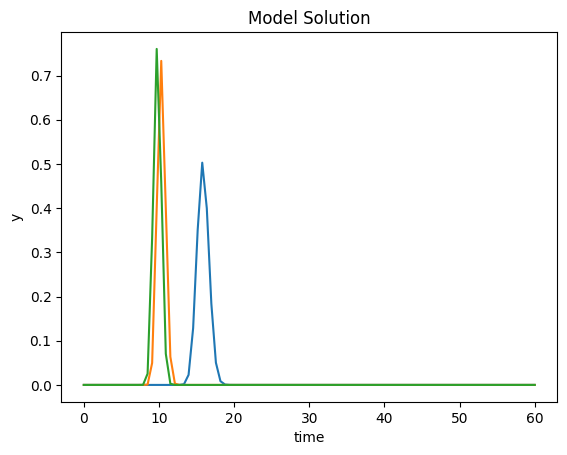

In [ ]:
# Plot results
plt.figure(3)
plt.plot(t,yplot)
plt.ylabel('y')
#plt.xlim(5,30)
plt.xlabel('time')
plt.title('Model Solution')
#plt.legend(["Ca","Cb","Cc"])

itempo = time.time() - it0   # time in sec
tmin = itempo #/60             # time in min / sec
#isec = np.remainder(itempo,60)

#print('time =',tmin,'min and',isec,'s')
print('time =', tmin,'s')

In [ ]:
f = open("Data_Henry_Fit.txt", "w")
np.savetxt(f, np.array([t, yplot[:,0],yplot[:,1],yplot[:,2]]).T)

## Visualização

In [ ]:
x = np.zeros(NELEM)
for i in range(1,NELEM+1):
  x[i-1] = (i*(COMP/NELEM))-((COMP/NELEM)/2.0)
# print(x)

X = np.zeros(len(t)*NELEM)
Y = np.zeros(len(t)*NELEM)
Z = np.zeros(len(t)*NELEM)

In [ ]:
for i in range(0,NELEM):
  for j in range(0,len(t)):
    X[j+i*len(t)] = x[i]
    Y[j+i*len(t)] = t[j]
    for k in range(0,NCOMP):
      Z[j+i*len(t)] += y[j,i+k*NELEM]
    #Z[j+i*len(t)] = y[j,i]

Aviso RuntimeWarning: The following kwargs were not used by contour: 'linewidth'


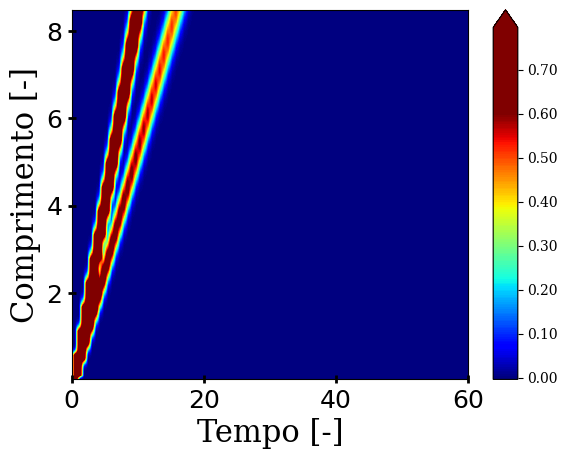

In [ ]:
import matplotlib.ticker as mticker

zhack = Z.reshape([NELEM,len(t)]).T*1
zhack[zhack>.8]=.8

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print(Z)

surf = ax.contourf(
    Y.reshape([NELEM,len(t)]).T,
    X.reshape([NELEM,len(t)]).T,
    zhack,
    levels=200,
    cmap=cm.jet,
    linewidth=0.1,
    vmin=0,
    vmax=0.6,
    extend='max'
    )

plt.rcParams.update({
    'font.family':'serif',
    'legend.fontsize':18,
    'figure.figsize':(8.4,4.8)
})

ticks_auto=np.arange(0,.8,.1)
ticklabels_auto=[f'{ticks_auto[i]:.2f}' for i in range(len(ticks_auto))]

cb = fig.colorbar(surf, shrink=1, aspect=15,

                                      ticks=ticks_auto,
                    format=mticker.FixedFormatter(ticklabels_auto),

                  )
csfont = {'fontname':'serif'}

#cb.set_ticks(np.linspace(0,0.6))

ax.set_ylabel('Comprimento [-]',**csfont,fontsize=22)
ax.set_xlabel('Tempo [-]',**csfont,fontsize=22)

#np.savetxt(g, np.array([X/COMP, Y/TOP, Z]).T)

ax.tick_params(axis='both', labelsize=18, length=6, width=2, direction='inout')




Aviso RuntimeWarning: The following kwargs were not used by contour: 'linewidth'


Text(0.5, 0, 'Tempo [-]')

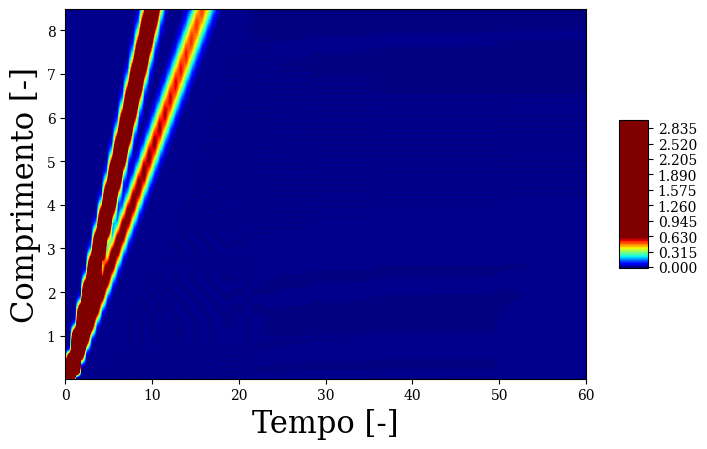

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#print(Z)

surf = ax.contourf(
    Y.reshape([NELEM,len(t)]).T,
    X.reshape([NELEM,len(t)]).T,
    Z.reshape([NELEM,len(t)]).T,
    levels=200,
    cmap=cm.jet,
    linewidth=0.1,
    vmin=0,
    vmax=0.6,
    )

plt.rcParams.update({
    'font.family':'serif',
    'legend.fontsize':18,
    'figure.figsize':(8.4,4.8)
})

cb = fig.colorbar(surf, shrink=0.4, aspect=5,)
csfont = {'fontname':'serif'}

#cb.set_ticks(np.linspace(0,0.6))

ax.set_ylabel('Comprimento [-]',**csfont,fontsize=22)
ax.set_xlabel('Tempo [-]',**csfont,fontsize=22)

#np.savetxt(g, np.array([X/COMP, Y/TOP, Z]).T)

